In [1]:
import os
import time
import sys
import itertools
import json
import librosa as lr
import librosa.display as lrd
import numpy as np
import os.path as osp

import matplotlib.pyplot as plt
import IPython.display as ipd
from sklearn.metrics import mean_squared_error

%matplotlib inline

sys.path.append("..")
from libs.utilities import load_autoencoder_lossfunc, load_autoencoder_model, get_func_name
from libs.processing import pink_noise, take_file_as_noise, \
    make_fragments, unmake_fragments, unmake_fragments_slice, \
    s_to_exp, exp_to_s, s_to_reim, reim_to_s, s_to_db, db_to_s , \
    normalize_spectrum, normalize_spectrum_clean, unnormalize_spectrum  


Using TensorFlow backend.
/home/christie/miniconda3/envs/denoising/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# LOAD LOGS (log order is different from argument list order!)
logs_path = '/home/rmicci18/SingleChannelDenoising_source/train_logs/phase1.json'

with open(logs_path) as f:
    logs = json.load(f)

In [13]:
# some parameters
input_path = '/data/riccardo_datasets/npr_news/ds0/train/NPR_News__03-15-2018_11PM_ET.wav'
sr = 16000
snr = 15
n_fft = 512
hop_length = 128
win_length = 512

frag_hop_length = 1

frag_win_length = 32
os.environ["CUDA_VISIBLE_DEVICES"] = '2'


In [14]:
# variable arguments
normalize_args = [True, False]

proc_func_args_1 = [
    (s_to_exp(1.0),   exp_to_s(1.0)),
    (s_to_exp(2.0),   exp_to_s(2.0)),
    (s_to_exp(1.0/6), exp_to_s(1.0/6)),
    (s_to_reim,       reim_to_s),
    (s_to_db,         db_to_s),
    (s_to_exp(2.0/3), exp_to_s(2.0/3)),
]
args_list_1 = list(itertools.product(normalize_args, proc_func_args_1))
print('\n'.join(['{:2}. {} {}'.format(i, 'norm' if arg[0] else '    ', get_func_name(arg[1][0])) for i,arg in enumerate(args_list_1)]))



 0. norm s_to_exp(1.000)
 1. norm s_to_exp(2.000)
 2. norm s_to_exp(0.167)
 3. norm s_to_reim
 4. norm s_to_db
 5. norm s_to_exp(0.667)
 6.      s_to_exp(1.000)
 7.      s_to_exp(2.000)
 8.      s_to_exp(0.167)
 9.      s_to_reim
10.      s_to_db
11.      s_to_exp(0.667)


In [15]:
normalize = [False] 
phase1bis = [True, False] 
time_slices_len= [1,3,16,32] #[0,1,2,3]
proc_func_args_1b = [
    (s_to_exp(1.0),   exp_to_s(1.0)),
    (s_to_exp(1.0/6), exp_to_s(1.0/6)),
    (s_to_reim,       reim_to_s),
    (s_to_db,         db_to_s),
    (s_to_exp(2.0/3), exp_to_s(2.0/3)),
]

args_list_1b = list(itertools.product(normalize, proc_func_args_1b, time_slices_len))
# print(args_list_2)
print('\n'.join(['{:2}. {} {} {}'.format(12+i, arg[0], get_func_name(arg[1][0]), arg[2]) for i,arg in enumerate(args_list_1b)]))


12. False s_to_exp(1.000) 1
13. False s_to_exp(1.000) 3
14. False s_to_exp(1.000) 16
15. False s_to_exp(1.000) 32
16. False s_to_exp(0.167) 1
17. False s_to_exp(0.167) 3
18. False s_to_exp(0.167) 16
19. False s_to_exp(0.167) 32
20. False s_to_reim 1
21. False s_to_reim 3
22. False s_to_reim 16
23. False s_to_reim 32
24. False s_to_db 1
25. False s_to_db 3
26. False s_to_db 16
27. False s_to_db 32
28. False s_to_exp(0.667) 1
29. False s_to_exp(0.667) 3
30. False s_to_exp(0.667) 16
31. False s_to_exp(0.667) 32


In [16]:
args_list = args_list_1 + args_list_1b
# # args_list = chain(args_list_1b, args_list_1)
# print(type(args_list), len(args_list))

In [17]:
 # load data from file name
x, _ = lr.load(input_path, sr=sr, duration=30, offset=120)

# apply noise!
x_noisy = pink_noise(x=x, sr=sr, snr=snr)

# convert to TF-domain
s = lr.stft(x, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
s_noisy = lr.stft(x_noisy, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    

In [18]:
def run_the_whole_thing(args_index, use_phase=True, trim_negatives=False):
    # collect variable arguments
#     print(args_list[args_index])
    if args_index < 12:
        normalize, proc_funcs = args_list[args_index]
        proc_func, unproc_func = proc_funcs
    else:
        normalize, proc_funcs, time_slice_len = args_list[args_index]
        proc_func, unproc_func = proc_funcs
    
#     print('[dn] Loading data from {}...'.format(input_path))
   # split into fragments
    s_frags = make_fragments(s, frag_hop_len=frag_hop_length, frag_win_len=frag_win_length)
    s_frags_noisy = make_fragments(s_noisy, frag_hop_len=frag_hop_length, frag_win_len=frag_win_length)
    # apply pre-processing (data representation)
    y_frags = proc_func(s_frags)
    y_frags_noisy = proc_func(s_frags_noisy)
#     print('[dn] Generated {} fragments with shape {}'.format(len(y_frags_noisy), y_frags_noisy[0].shape))
    # normalization factors
    nf_frags = np.empty((len(y_frags), 2))
    nf_frags_noisy = np.empty((len(y_frags_noisy), 2))
    y_frags_n = np.zeros_like(y_frags)
    y_frags_noisy_n = np.zeros_like(y_frags_noisy)

    # normalize fragments (batch-wise)
    #y_frags_noisy_n, nf_frags_noisy = normalize_spectrum(y_frags_noisy)
    #print(nf_frags_noisy)


    # normalize fragments (individually)
    for i in range(len(y_frags_noisy)):
        frag_normalized, frag_norm_factors = normalize_spectrum(y_frags[i])
        frag_normalized_noisy, frag_norm_factors_noisy = normalize_spectrum(y_frags_noisy[i])
        y_frags_n[i] = frag_normalized if normalize else y_frags[i]
        y_frags_noisy_n[i] = frag_normalized_noisy if normalize else y_frags_noisy[i]
        nf_frags_noisy[i] = frag_norm_factors_noisy
        nf_frags[i] = frag_norm_factors

#     y_frags_noisy_n[::2] = 0
#     y_frags_noisy_n[1::2] = 1
    
    #### LOAD TRAINED MODEL ###
    model_destination_base = '/data/riccardo_models/denoising/phase1'
    if args_index < 12:
#         print('Phase 1')
        model_destination_name = '{}_{}.h5'.format(get_func_name(proc_func), 'norm' if normalize else 'no')
    else:
#         print('Phase 1 bis')
        model_destination_name = 'phase1bis_{}_{}.h5'.format(get_func_name(proc_func), time_slice_len)                                          
    model_path = osp.join(model_destination_base, model_destination_name)
    
    if args_index < 12:
        time_slice = frag_win_length // 2 - frag_hop_length // 2    
    else:
        time_slice = slice(np.int(frag_win_length//2 - time_slice_len/2), \
                         np.int(frag_win_length//2 + time_slice_len/2)) 
#     print("time_slice:{}".format(time_slice))
    model, lossfunc = load_autoencoder_model(model_path, time_slice=time_slice)


    ### PREDICT DATA ###
#     print('[dn] Predicting with trained model...')
    y_frags_pred = model.predict(y_frags_noisy_n)
#     y_frags_pred = y_frags_noisy_n
#     print('[dn] Prediction finished! Generated {} fragments'.format(len(y_frags_pred)))


    ### PLOT A FEW PREDICTED FRAGMENTS ###
    specrange = np.linspace(0, len(y_frags_pred), 3, dtype=int)
    sample_specs = []
#     print(list(specrange))

    plt.figure(figsize=(18, 6))
    plt.suptitle('Clean (true), noisy, and predicted sample fragments (normalized)')
    rangespan = len(specrange)
    j = 1
    y_frags_pred_dn = np.zeros_like(y_frags_pred)
    for i in range(len(y_frags_pred)):
        # un-normalize (individually)
        y_frags_pred_dn[i] = unnormalize_spectrum(y_frags_pred[i], nf_frags_noisy[i]) if normalize else y_frags_pred[i]
        if i in specrange:  
            sample_specs.append((y_frags_noisy_n[i,...,0], y_frags_pred[i,...,0]))
#             plt.subplot(3,rangespan,j)
#             lrd.specshow(lr.amplitude_to_db(y_frags_n[i,...,0]), vmin=-10, vmax=5, cmap='coolwarm')

#             plt.subplot(3,rangespan,rangespan+j)
#             lrd.specshow(lr.amplitude_to_db(y_frags_noisy_n[i,...,0]), vmin=-10, vmax=5, cmap='coolwarm')

#             plt.subplot(3,rangespan,rangespan*2+j)
#             lrd.specshow(lr.amplitude_to_db(y_frags_pred[i,...,0]), vmin=-10, vmax=5, cmap='coolwarm')

            j += 1


    # un-normalize (batch-wise)
    #y_frags_pred_dn = unnormalize_spectrum(y_frags_pred, nf_frags_noisy)

    # trim negative values
    if trim_negatives:
        y_frags_pred[y_frags_pred < 0] = 0
    s_pred = unproc_func(y_frags_pred, s_frags_noisy) if use_phase else unproc_func(y_frags_pred)

    # undo fragments
    if args_index < 12: 
        s_pred = unmake_fragments(s_pred, frag_hop_len=frag_hop_length, frag_win_len=frag_win_length)
    else:
        s_pred = unmake_fragments_slice(s_pred, frag_hop_len=frag_hop_length, frag_win_len=frag_win_length, time_slice=time_slice)
    
    # get waveform
    x_pred = lr.istft(s_pred, hop_length=hop_length, win_length=win_length)



    ### PLOT RESULT AND LISTEN ###
#     duration = 20
#     offset = 2
#     l = lr.time_to_frames(duration, sr=sr, n_fft=n_fft, hop_length=hop_length)
#     o = lr.time_to_frames(offset, sr=sr, n_fft=n_fft, hop_length=hop_length)
#     print(o,l)

#     plt.figure(figsize=(18, 5))
#     plt.suptitle('True and predicted spectrograms (de-normalized, {} seconds)'.format(duration))

#     plt.subplot(211)
#     lrd.specshow(lr.amplitude_to_db(np.abs(s[:,o:o+l])), vmin=-50, vmax=25, cmap='coolwarm')
#     plt.colorbar()

#     plt.subplot(212)
#     lrd.specshow(lr.amplitude_to_db(np.abs(s_pred[:,o:o+l])), vmin=-50, vmax=25, cmap='coolwarm')
#     plt.colorbar()
    
    print('done!')
    return x_pred, s_pred, sample_specs
    

In [21]:
# TEST VARIOUS MODELS HERE
inds_2_check = [29,30,31,13,14,25,26,27]
for i,ind in enumerate(inds_2_check):
    if ind in range(29,32):
        trim_negatives = True
    else:
        trim_negatives = False
        
    _, s_pred, _ = run_the_whole_thing(ind, use_phase=True, trim_negatives=trim_negatives)
        
    time_slice_len = time_slices_len[i%3+1]
    time_slice = slice(np.int(frag_win_length//2 - time_slice_len/2), 
                         np.int(frag_win_length//2 + time_slice_len/2)) 
    t_start = time_slice.start

    ## trimming
    s_pred_2 = s_pred[:, frag_win_length:-frag_win_length]
    s_noisy_2 = s_noisy[:, frag_win_length: s_pred_2.shape[1]+frag_win_length]
    s_2 = s[:, frag_win_length: s_pred_2.shape[1]+frag_win_length]

    snr = s_pred_2**2 / (s_noisy_2 - s_2)**2
    sdr =  s_2**2 / (s_2 - s_pred_2)**2
    print('snr :',np.mean(lr.power_to_db(np.abs(snr))))
    print('sdr :',np.mean(lr.power_to_db(np.abs(sdr))))
    
# ipd.Audio(x_pred, rate=sr)


[u] Loading autoencoder model from /data/riccardo_models/denoising/phase1/phase1bis_s_to_exp(0.667)_3.h5
done!
snr : 15.466013387696414
sdr : -4.630255804299211
[u] Loading autoencoder model from /data/riccardo_models/denoising/phase1/phase1bis_s_to_exp(0.667)_16.h5
done!
snr : 15.786763198403937
sdr : -2.1969449315720495
[u] Loading autoencoder model from /data/riccardo_models/denoising/phase1/phase1bis_s_to_exp(0.667)_32.h5
done!
snr : 17.345503362194304
sdr : 7.142983405335569
[u] Loading autoencoder model from /data/riccardo_models/denoising/phase1/phase1bis_s_to_exp(1.000)_3.h5
done!
snr : 16.79741313766468
sdr : 9.16191147667167
[u] Loading autoencoder model from /data/riccardo_models/denoising/phase1/phase1bis_s_to_exp(1.000)_16.h5
done!
snr : 15.954424111541305
sdr : 6.1279862134450385
[u] Loading autoencoder model from /data/riccardo_models/denoising/phase1/phase1bis_s_to_db_3.h5
done!
snr : 17.029221243730156
sdr : 4.387484687833944
[u] Loading autoencoder model from /data/ri

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

In [79]:
c = 4
c%3 + 1

2

In [10]:

time_slice_len = time_slices_len[2]
time_slice = slice(np.int(frag_win_length//2 - time_slice_len/2), 
                     np.int(frag_win_length//2 + time_slice_len/2)) 
i = time_slice.start

In [24]:
## trimming
s_pred_2 = s_pred[:, frag_win_length:-frag_win_length]
s_noisy_2 = s_noisy[:, frag_win_length: s_pred_2.shape[1]+frag_win_length]
s_2 = s[:, frag_win_length: s_pred_2.shape[1]+frag_win_length]

print(s_pred.shape, s_noisy.shape, s.shape)
print(s_pred_2.shape, s_noisy_2.shape, s_2.shape)

(257, 3742) (257, 3751) (257, 3751)
(257, 3678) (257, 3678) (257, 3678)


snr : 34.29581490856378
sdr : 20.571553608695655


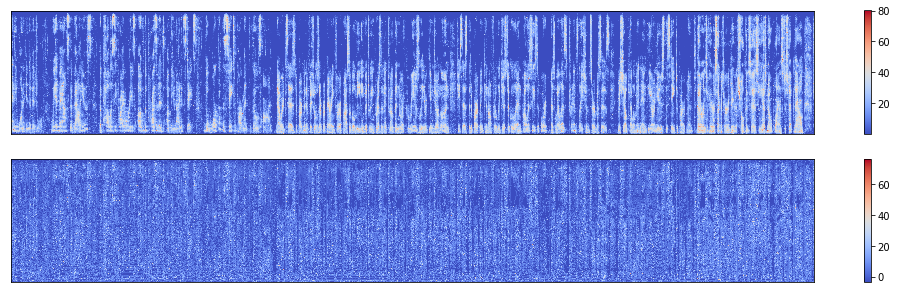

In [44]:
## Evaluation 

## SNR
snr = s_pred_2**2 / (s_noisy_2 - s_2)**2
sdr =  s_2**2 / (s_2 - s_pred_2)**2 
print('snr :',np.mean(lr.power_to_db(np.abs(snr))))
print('sdr :',np.mean(lr.power_to_db(np.abs(sdr))))
# snr.shape

plt.figure(figsize=(18, 5)), 
plt.subplot(2,1,1)
lrd.specshow(lr.power_to_db(np.abs(snr)), cmap='coolwarm')
plt.colorbar()

plt.subplot(2,1,2)
lrd.specshow(lr.power_to_db(sdr), cmap='coolwarm')
plt.colorbar()

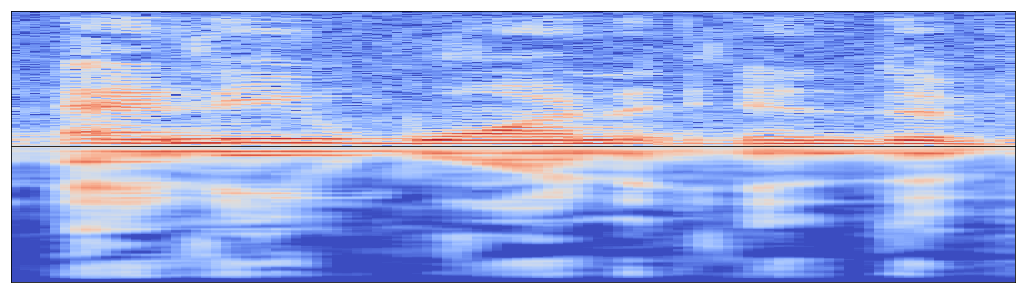

In [28]:
plt.figure(figsize=(18, 5))
plt.subplot(211)
lrd.specshow(lr.amplitude_to_db(np.abs(s_noisy_2[:,:100])), vmin=-50, vmax=25, cmap='coolwarm') #[:,:100]

plt.subplot(212)
lrd.specshow(lr.amplitude_to_db(np.abs(s_pred_2[::-1,:100])), vmin=-50, vmax=25, cmap='coolwarm')
plt.subplots_adjust(wspace=0, hspace=0)

In [42]:
# plt.figure(figsize=(18, 5))
# plt.subplot(211)
# lrd.specshow(lr.amplitude_to_db(np.abs(s_noisy[:,-(100):])), vmin=-50, vmax=25, cmap='coolwarm')

# plt.subplot(212)
# lrd.specshow(lr.amplitude_to_db(np.abs(s_pred[::-1,-100:])), vmin=-50, vmax=25, cmap='coolwarm')
# plt.subplots_adjust(wspace=0, hspace=0)

In [16]:
print(s_pred.shape, s_noisy.shape)


(257, 3742) (257, 3751)


In [17]:
ipd.Audio(x, rate=sr)

In [18]:
###############################

In [19]:

ipd.Audio(x_noisy, rate=sr)

248 2498


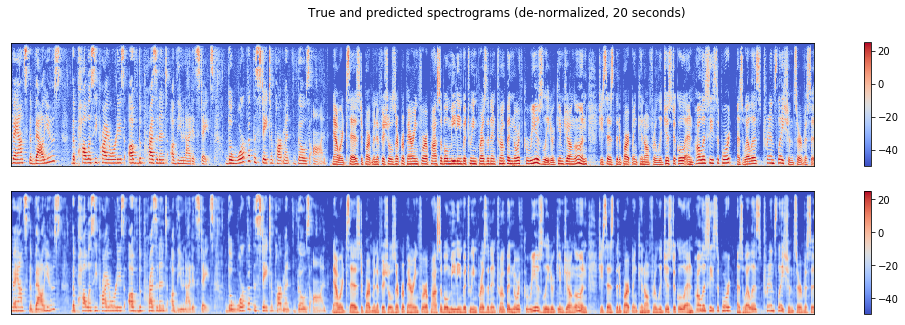

In [20]:
### PLOT RESULT AND LISTEN ###
duration = 20
offset = 2
l = lr.time_to_frames(duration, sr=sr, n_fft=n_fft, hop_length=hop_length)
o = lr.time_to_frames(offset, sr=sr, n_fft=n_fft, hop_length=hop_length)
print(o,l)

plt.figure(figsize=(18, 5))
plt.suptitle('True and predicted spectrograms (de-normalized, {} seconds)'.format(duration))

plt.subplot(211)
lrd.specshow(lr.amplitude_to_db(np.abs(s[:,o:o+l])), vmin=-50, vmax=25, cmap='coolwarm')
plt.colorbar()

plt.subplot(212)
lrd.specshow(lr.amplitude_to_db(np.abs(s_pred[:,o:o+l])), vmin=-50, vmax=25, cmap='coolwarm')
plt.colorbar()

In [41]:
################ SNR and other evaluation metrics

## Source evaluation
from mir_eval.separation import bss_eval_sources
result = bss_eval_sources(np.array([x, x_noisy-x]), np.array([x_pred, x_noisy-x_pred]))
print(result) # D, I, A

## SNR
# snr = s_pred**2 / (s_noisy - s)**2

# snr.shape

ValueError: operands could not be broadcast together with shapes (480000,) (478848,) 

In [ ]:
print(result)